# Abalone Age Prediction using Multi-Layer Perceptron (MLP)
### CSCI218 - Foundations of AI

---
**Objective:** Predict the age of abalone (Rings + 1.5) from physical measurements using a Multi-Layer Perceptron Neural Network

> **Dataset Source:** UCI Machine Learning Repository — Abalone Dataset  
> **Target:** Rings (Age = Rings + 1.5)  
> **Task Type:** Regression → Converted to Classification for accuracy measurement

#1. Data Loading
#2. Data Engineering
#3. Feature Engineering: Creating `Volume` and `AgeClass` columns
#4. Data Splitting
#5. Scaling (Data Preprocessing)
##*   checking and handling missing values and dropping duplicates (none)
##*   One-Hot Encoding `Sex` and `AgeClass` columns
##*   Normalization (Scaling)
##*   Stratification





##1.   Checking and handling Missing Values and Dropping Duplicates
### - none were found
##2.   One-Hot Encoding `Sex` and `AgeClass` columns

###   - `AgeClass` column with binary values (1 = True, 0 = False), 1 for abalones with more than 7 rings, 0 for those with less than
###   - producing 3 new columns from original `Sex` column based on categorical values: `Sex_F` , `Sex_M` and `Sex_I`   


##3.   Normalization (Scaling) of X (feature) sets
### - prevents features with larger scales from dominating models that are sensitive to magnitude (eg. Neural Networks)
### - helps gradient-based algorithms (eg. Neural Networks)converge faster by keeping feature values in a similar range

##4.   Stratification based on `AgeClass` column
### - ensures that proportion of **Juvenile (AgeClass = 0)** and **Adult (AgeClass = 1)** abalones are approximately the same in the testing and training sets
### - reduce the variance and error of your estimates by minimizing the sampling error
### - avoids bias and improves performance and generalization of models


In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
import time

#Data Loading
path = kagglehub.dataset_download("rodolfomendes/abalone-dataset")
df = pd.read_csv(f"{path}/abalone.csv")

#Feature Engineering of Volume Column
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
#remove duplicates
df = df.drop_duplicates()

# broadened data boundaries: Juvenile (<=7) and Adult (>=8)
#One-Hot Encoding
df['AgeClass'] = (df['Rings'] > 7).astype(int)
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex')

X = df.drop(['Rings', 'AgeClass'], axis=1)
y_reg = df['Rings']
y_cls = df['AgeClass']

#Data Splitting into Train and Test sets with Stratification
X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(
    X, y_reg, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

100%|██████████| 57.3k/57.3k [00:00<00:00, 2.11MB/s]

Extracting files...


## Model(s) Setup and Hyperparameter Tuning

###Models:

###1.   Polynomial Regression
###2.   Linear Regression
###3.   Keras MLP
###4.   Gaussian Naive Bayes
###5.   Random Forest Regressor



### Training and Testing Linear Regression and Polynomial Regression Models

In [2]:
#linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_reg)
lr_predictions = lr_model.predict(X_test_scaled)

# polynomial regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_reg)
poly_predictions = poly_model.predict(X_test_poly)

### Tuning and Testing RandomForestRegressor

#### - `cv=5`: data split into 5 parts, through 5 iterations, 4 parts are trained and 1 part is validated through rotation

#### - `rf`: specify model to perform search over param grid (in this case RandomForestRegressor)

In [3]:
# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200], #number of trees in the forest
    'max_depth': [10, 20, None], #helps prevent overfitting
    'min_samples_split': [2, 5], #min. no. of samples required to split an internal node
    'max_features': ['sqrt', 'log2'] #no. of features to consider when looking for best split ('sqrt' or 'log2' of total no. of features)
}
start_time_rf = time.time()
rf = RandomForestRegressor(random_state=42) #setting fixed random state ensures same results will be acheieved regardless of runs (reproducibility)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train_reg)
best_rf = grid_search.best_estimator_
rf_predictions = best_rf.predict(X_test_scaled)
rf_runtime = time.time() - start_time_rf

`loss='mse'`: loss function MLP uses to measure how well it performs during training

`batch_size=32`:
- training data divided into smaller subsets (batches)
- model processes 32 samples at a time before updating internal weights
- training process is more efficient and stable

`validation_split=0.1`: tells model to set aside 10% of training data for validation so that model's performance is **evaluated** on the validation set **after each epoch**

In [4]:
# build MLP model (shallow neural network with 1 hidden layer)
start_time_mlp = time.time()
mlp_model = models.Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
mlp_model.fit(X_train_scaled, y_train_reg, epochs=100, batch_size=32, verbose=0, validation_split=0.1)
mlp_predictions = mlp_model.predict(X_test_scaled).flatten()
mlp_runtime = time.time() - start_time_mlp

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


### Gaussian Naive Bayes Model Setup

In [5]:
# GaussianNB implementation
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train_cls)
gnb_class_predictions = gnb_model.predict(X_test_scaled)

## Model Evaluation (Compare Evaluation Results and Metrics)

In [6]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

# GaussianNB Evaluation
start_time = time.time()
gnb_model.fit(X_train_scaled, y_train_cls)
gnb_class_predictions = gnb_model.predict(X_test_scaled)
gnb_runtime = time.time() - start_time

print(f"GaussianNB Accuracy: {accuracy_score(y_test_cls, gnb_class_predictions):.4f}")
print(f"GaussianNB Runtime: {gnb_runtime:.4f} seconds")
print(classification_report(y_test_cls, gnb_class_predictions, target_names=['Juvenile', 'Adult']))
print("-" * 30)

#Linear Regression Evaluation
start_time = time.time()
lr_model.fit(X_train_scaled, y_train_reg)
lr_predictions = lr_model.predict(X_test_scaled)
lr_runtime = time.time() - start_time

print(f"Linear Regression MAE: {mean_absolute_error(y_test_reg, lr_predictions):.4f}")
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test_reg, lr_predictions)):.4f}")
print(f"Linear Regression R2: {r2_score(y_test_reg, lr_predictions):.4f}")
print(f"Linear Regression Runtime: {lr_runtime:.4f} seconds")
print("-" * 30)

# Polynomial Regression Evaluation
start_time = time.time()
poly_model.fit(X_train_poly, y_train_reg)
poly_predictions = poly_model.predict(X_test_poly)
poly_runtime = time.time() - start_time

print(f"Polynomial Regression MAE: {mean_absolute_error(y_test_reg, poly_predictions):.4f}")
print(f"Polynomial Regression RMSE: {np.sqrt(mean_squared_error(y_test_reg, poly_predictions)):.4f}")
print(f"Polynomial Regression R2: {r2_score(y_test_reg, poly_predictions):.4f}")
print(f"Polynomial Regression Runtime: {poly_runtime:.4f} seconds")
print("-" * 30)

# Random Forest Evaluation (Includes GridSearchCV time)
rf_runtime = time.time() - start_time_rf
print(f"Best Parameters for random forest: {grid_search.best_params_}")
print(f"Random Forest MAE: {mean_absolute_error(y_test_reg, rf_predictions):.4f}")
print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test_reg, rf_predictions)):.4f}")
print(f"Random Forest R2: {r2_score(y_test_reg, rf_predictions):.4f}")
print(f"Random Forest Runtime: {rf_runtime:.4f} seconds")
print("-" * 30)

# 5. Keras MLP Evaluation
mlp_runtime = time.time() - start_time_mlp
print(f"Keras MLP MAE: {mean_absolute_error(y_test_reg, mlp_predictions):.4f}")
print(f"Keras MLP RMSE: {np.sqrt(mean_squared_error(y_test_reg, mlp_predictions)):.4f}")
print(f"Keras MLP R2: {r2_score(y_test_reg, mlp_predictions):.4f}")
print(f"Keras MLP Runtime: {mlp_runtime:.4f} seconds")

GaussianNB Accuracy: 0.8433
GaussianNB Runtime: 0.0035 seconds
              precision    recall  f1-score   support

    Juvenile       0.57      0.89      0.70       168
       Adult       0.97      0.83      0.89       668

    accuracy                           0.84       836
   macro avg       0.77      0.86      0.80       836
weighted avg       0.89      0.84      0.85       836

------------------------------
Linear Regression MAE: 1.5654
Linear Regression RMSE: 2.1943
Linear Regression R2: 0.5439
Linear Regression Runtime: 0.0023 seconds
------------------------------
Polynomial Regression MAE: 1.5057
Polynomial Regression RMSE: 2.1663
Polynomial Regression R2: 0.5554
Polynomial Regression Runtime: 0.0172 seconds
------------------------------
Best Parameters for random forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Random Forest MAE: 1.5400
Random Forest RMSE: 2.2430
Random Forest R2: 0.5234
Random Forest Runtime: 163.3606 secon

### **Insights:**
#### 1. GNB model is more confident in predicting **Adult** abalones due to a **much higher precision** (correct 97% of the time) as compared to the Juvenile class (correct 57% of the time)

#### 2. GNB model correctly identified more **Juvenile** abalones due to **slightly higher recall** of 0.89 as compared to Adult class with recall of 0.83.


## Data Visualisation and Analysis after Model Evaluation

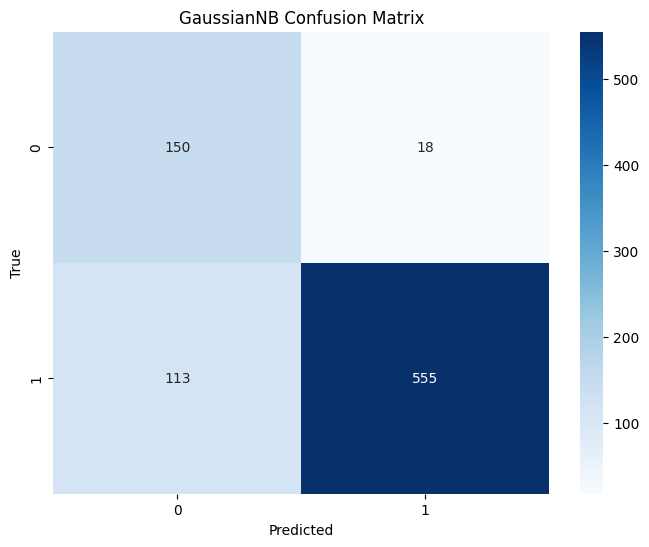

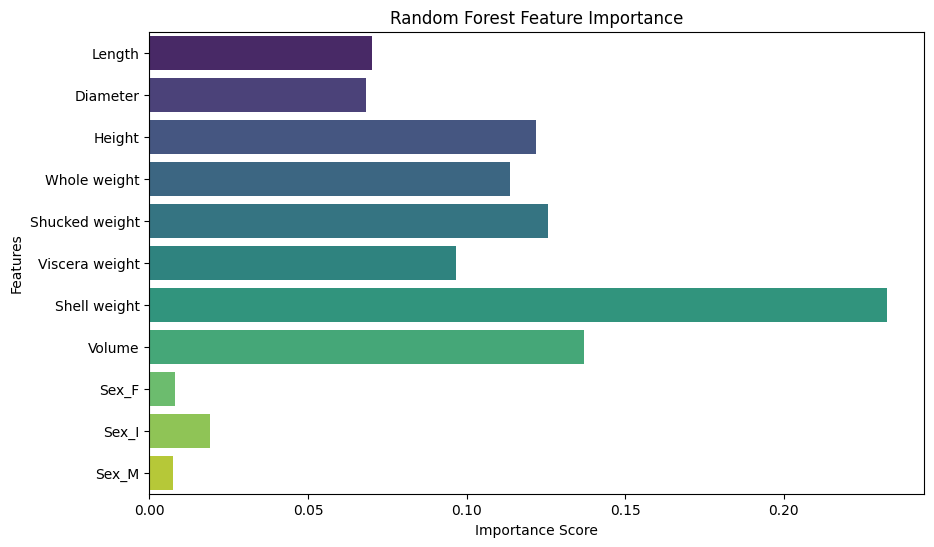

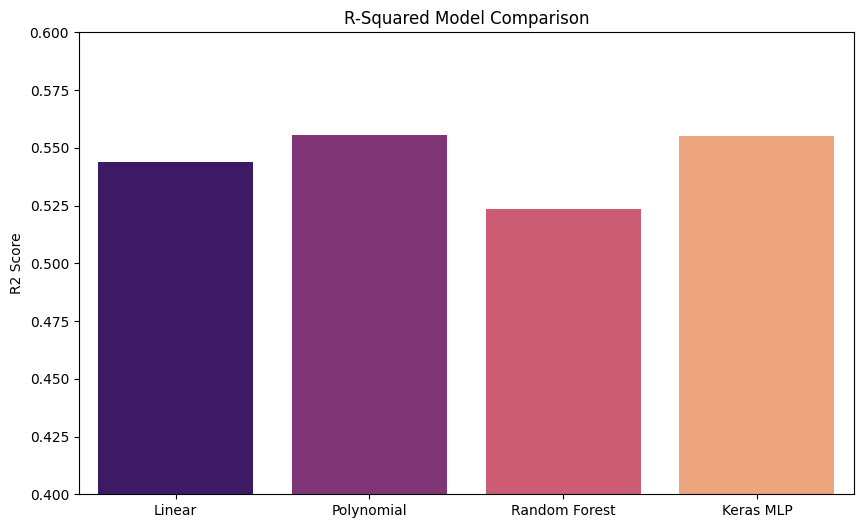

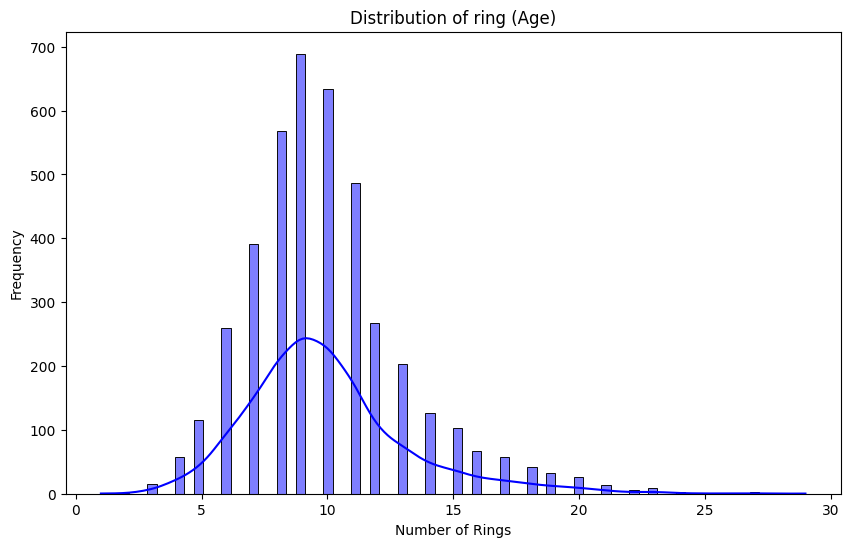

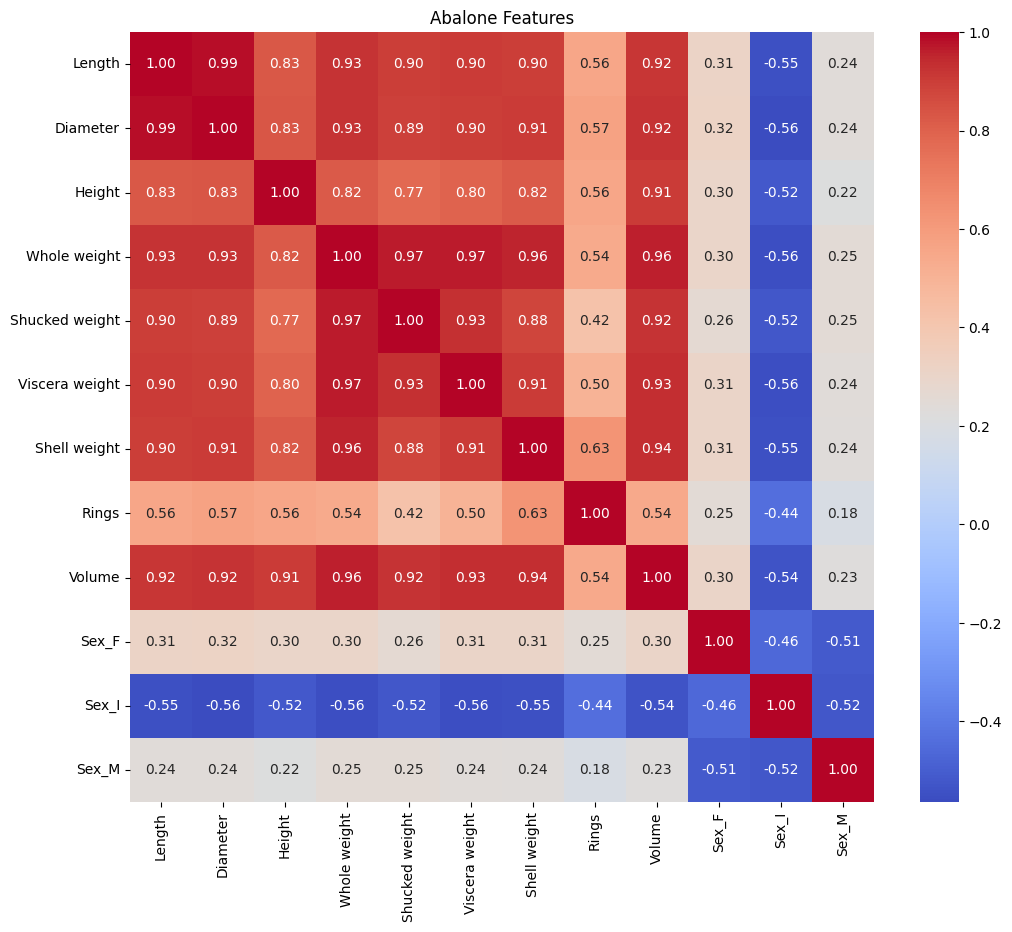

In [8]:
#GaussianNB confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_cls, gnb_class_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('GaussianNB Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Feature Importance for random forest
importances = best_rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, hue=feature_names, palette='viridis', legend=False)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Calculate R2 scores as they were not stored in variables previously
lr_r2 = r2_score(y_test_reg, lr_predictions)
poly_r2 = r2_score(y_test_reg, poly_predictions)
rf_r2 = r2_score(y_test_reg, rf_predictions)
mlp_r2 = r2_score(y_test_reg, mlp_predictions)

#model comparison barplot (R2 score)
models = ['Linear', 'Polynomial', 'Random Forest', 'Keras MLP']
r2_scores = [lr_r2, poly_r2, rf_r2, mlp_r2]
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=r2_scores, hue=models, palette='magma', legend=False)
plt.title('R-Squared Model Comparison')
plt.ylim(0.4, 0.6)
plt.ylabel('R2 Score')
plt.show()


#data class distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Rings'], kde=True, color='blue')
plt.title('Distribution of ring (Age)')
plt.xlabel('Number of Rings')
plt.ylabel('Frequency')
plt.show()

# Correlation Matrix between physical features
plt.figure(figsize=(12, 10))
correlation_matrix = df.drop(['AgeClass'], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Abalone Features')
plt.show()

### Insights:
#### 1. GaussianNB model correctly identified more **Adult** abalones due to higher **True Positives** (correct label)
#### 2. Shell Weight is the most influential feature affecting the performance of RandomForestRegressor
#### 3. **MLP** has the **best model performance** based on **R2** metric
#### 4. Most of the abalones have 9 rings (highest distribution)
#### 5. All physical measurement features (except Sex) are positively and highly correlated with `Age` (and one another) indicating that larger and heavier abalones in the dataset tend to be older.

#### **Intercorrelated Features:**
#### 1) Length and Diameter
#### 2) Whole weight and Shucked weight


#IGNORE NEXT LINE: just to print to html and convert to pdf to see full code and outputs

In [9]:
!jupyter nbconvert --to html "/content/drive/MyDrive/FAI_GrpAssn/CSCI218_FT24.ipynb"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/FAI_GrpAssn/CSCI218_FT24.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--Jupyt